![](https://storage.googleapis.com/coronawhy-vt/PowerBIData/HeaderForKaggle.png)

## Table of Content
1. [Preamble](#preamble)
2. [Executive Summary](#exec_summary)
3. [Executable Code](#code)
4. [List of Contributors](#contrib)


# 1. Preamble <a id="preamble"></a>
This is a notebook created by a collaborative effort of the Task-VT sub-team within the CoronaWhy research consortium. For more information about CoronaWhy:
- Visit our [website](https://www.coronawhy.org) to learn more.
- Read our [story](https://medium.com/@arturkiulian/im-an-ai-researcher-and-here-s-how-i-fight-corona-1e0aa8f3e714).
- Visit our [main notebook](https://www.kaggle.com/arturkiulian/coronawhy-org-global-collaboration-join-slack) for historical context on how this community started.

# 2. Executive Summary <a id="exec_summary"></a>

**The primary deliverables from this work are the visualizations embedded in the notebook below.  For optimum viewing experience in full-screen, we recommend visiting these links:**

[COVID-19 Drug Treatment Explorer](https://app.powerbi.com/view?r=eyJrIjoiMzRlZTliMTItZGE0OS00ZTNjLTllM2YtMTlmN2ZhMDRkYWRmIiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9)

<a href="https://app.powerbi.com/view?r=eyJrIjoiMzRlZTliMTItZGE0OS00ZTNjLTllM2YtMTlmN2ZhMDRkYWRmIiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9"> <img width="300" src="https://storage.googleapis.com/coronawhy-vt/PowerBIData/Dashboard1.png"> 


[COVID-19 Drug Treatment Matrix](https://app.powerbi.com/view?r=eyJrIjoiMjc4NDZkYzktZmUyZC00ZThkLTkyYjAtY2EzNzk2ZDliOTk2IiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9)

<a href="https://app.powerbi.com/view?r=eyJrIjoiMjc4NDZkYzktZmUyZC00ZThkLTkyYjAtY2EzNzk2ZDliOTk2IiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9"> <img width="300"  src="https://storage.googleapis.com/coronawhy-vt/PowerBIData/Dashboard2.png"> </a>



**Methodology**

This notebook is targetted at the Task: "What do we know about vaccines and therapeutics?", and in particular presents evidence for the sub-task concerning "Effectiveness of drugs being developed and tried to treat COVID-19 patients".  

To address this question we sought to identify all papers in the dataset which indicated that a named drug had been used or considered as a treatment / therapy for COVID-19.  We consider every named drug that is prescribable in the United States, as catalogued in the publicly available RxNorm database, strip out problematic terms using word-lists, and combine with drug lists of interest from the WHO and Excelra. 

Sentences are extracted from each paper indicating what is stated about this drug as a treatment.  These statements are classified by relevance to COVID-19: whether they are mentioned in the same paragraph or paper as the drug, for example.  The statements can also be sorted by drug name and section of paper where it is mentioned (title/abstract/elsewhere).  

We provide the user with the option to keep all sentences with drug-treat co-occurrences (Loose), remove false positive drug treatments using negation detection (Medium) or by using both negation detection and a pre-trained BERT sentence classifier (Tight).

Two tools for data visualization have been developed. One that allows browsing of statements about drugs in a treatment context providing journal and citation information, dates, and links to articles. Paper titles and abstracts and contexts are browsable in connection with each sentence. A second visualization allows for cross-categorization between drug name and study type in the paper: clinical, pre-clinical, in-silico or in-vitro, assessed by word keyword search in the titles and abstracts.

The code in later sections of this notebook generates the data that feeds the above visualizations. It uses only the raw CORD-19 data release and some cited publically available data tables, and has a run-time of a few hours.  The above GUI can be used without re-running this notebook to view the results. To facilitate speed of execution we include in this notebook some intermediate files, uploaded to the TextMatchVT Kaggle Dataset, so that the most interesting parts of the code can be executed with more rapid turnaround.

We hope that this tool may prove to be a valuable resource for anyone who is trying to navigate the wide and rapidly evolving literature on treatments for COVID-19, collecting into one place all statements that have been made about a large array of drug candidates that could be of relevance.

DISCLAIMER: We do NOT claim to be offering any medical advice with this tool. This dashboard is simply intended as a means of facilitating exploration of drug treatment mentions in CORD-19 literature. Proper due diligence, reading the full paper, and understanding the full context of these drug mentions will be required before considering any medical implications. We stress that this tool is meant for EXPLORATION.




In [120]:
from IPython.display import IFrame
IFrame('https://app.powerbi.com/view?r=eyJrIjoiMzRlZTliMTItZGE0OS00ZTNjLTllM2YtMTlmN2ZhMDRkYWRmIiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9', width=800, height=500)

In [121]:
IFrame('https://app.powerbi.com/view?r=eyJrIjoiMjc4NDZkYzktZmUyZC00ZThkLTkyYjAtY2EzNzk2ZDliOTk2IiwidCI6ImRjNTQ3MWFjLWM4NmMtNGNiZS04YTVjLTI0MzUxZGRmMjRjOCIsImMiOjN9', width=800, height=500)

# 3. Executable Code <a id="code"></a>

In the following sections, the code that produces the visualizible output will be
presented. Running the full notebook will produce the output files used above.

### Imports and Installs

In [122]:
# If True, use the SciSpacy package for tokenizing, with dictionary
# en_core_sci_lg-0.2.4
# otherwise, use Spacy, with en_core_web_lg
UseSciSpacy=True

#If True, enrich CORD-19 metadata with cleaned metadata
# from CoronaWhy datasets
InsertCiteData=True

#If True, test for sentence negations
CalculateNegations=True

# If True, re-run the text matching code.
# Warning, if it takes along time! Intermediate data 
# from this step is provided with the notebook.
RunMatching=False

In [123]:
import numpy as np
import pylab
import pandas as pd
import json
import os
import re
import spacy
import numpy as np  
import pandas as pd 
import matplotlib
import spacy
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

if(UseSciSpacy):
   #Instal SciSpacy
    !pip install -U scispacy
    !pip install -U https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
    import scispacy
    nlp=spacy.load("/opt/conda/lib/python3.6/site-packages/en_core_sci_lg/en_core_sci_lg-0.2.4/", disable=["tagger"])
else:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')

Requirement already up-to-date: scispacy in /opt/conda/lib/python3.6/site-packages (0.2.4)
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz (500.6 MB)


  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-py3-none-any.whl size=501343161 sha256=81859f4e4f6fb16fdc17c7861a996e69571695a5a2840bc81f5b0d55034392a7
  Stored in directory: /root/.cache/pip/wheels/43/12/d5/dd85b5deab7738797c4d5358672df3616dda39acf570a3ef96
Successfully built en-core-sci-lg
  Attempting uninstall: en-core-sci-lg
    Found existing installation: en-core-sci-lg 0.2.4
    Uninstalling en-core-sci-lg-0.2.4:
      Successfully uninstalled en-core-sci-lg-0.2.4


In [124]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6}

matplotlib.rc('font', **font)

### Drug Search Term List Construction 

This section uses publically source-able data to construct a list of drug terms to search.

The starting point is the list of all prescribable drugs from the RxNorm database:
   https://download.nlm.nih.gov/rxnorm/RxNorm_full_prescribe_03022020.zip

From this list we then remove the following un-useful names:
1. names of chemical elements, from this periodic table:
  https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee
2. names of animals, from this list: 
  https://gist.github.com/atduskgreg/3cf8ef48cb0d29cf151bedad81553a54   
3. names of fruits and vegetables, from this list: 
  https://alphabetizer.flap.tv/lists/list-of-fruits-and-vegetables.php
4. Remove dosage terms by regular expression
5. Remove delivery terms and source terms, using hand-curated lists

We then remove terms with dosage or delivery information,
or unusual punctuation within the drug name.

We restrict to drug names of more than 5 characters and consisting of between 1 and 3 words.
  
For convenience these publically available files have been collected in the kaggle
 directory rxnorm_inputdata.

In [125]:
# Open the RxNorm input file
file=open("/kaggle/input/rxnorm-inputdata/RxNorm_full_prescribe_03022020/rrf/RXNCONSO.RRF",'r').readlines()
names=[]
for line in file:
    
    names.append(line.split("|")[14].lower())
names=np.unique(names)

# Load up elements
Elements=pd.read_csv("/kaggle/input/rxnorm-inputdata/Elements.csv")
ElementNames = Elements.Element.str.lower()

# Load up animals, 
AnimalsRaw=open("/kaggle/input/rxnorm-inputdata/animals.txt",'r').readlines()
AnimalNames=[]
for a in AnimalsRaw:
    if not " " in a:
        AnimalNames.append(a[:-1].lower())

# Load up fruit and veg
FruitVegRaw=open("/kaggle/input/rxnorm-inputdata/FruitAndVeg.txt",'r').readlines()
FruitVegNames=[]
for a in FruitVegRaw:
    if not " " in a:
        FruitVegNames.append(nlp(a[:-1].lower())[0].lemma_)

# And a few hand-spotted bad ones        
Fakes=['injection','glucose','perform','ethanol','methanol','paraffin','soybean','horseradish','ginger','mouthwash','oregano','formaldehyde','alcohol']

 
# Apply the filter        
filterednames=[]
for name in names:
    if (not name  in AnimalNames) and (not name  in FruitVegNames)  and (not name  in ElementNames.values) and (not name in Fakes):
        filterednames.append(name)

# Now begin more advanced list cleaning step:        
        
dnames = filterednames
dnames = [ x.replace("\n","") for x in dnames]

dose_terms = open("/kaggle/input/rxnorm-inputdata/dosage terms.txt").readlines()
dose_terms = [ x.replace("\n","") for x in dose_terms]

delivery_terms = open("/kaggle/input/rxnorm-inputdata/delivery terms.txt").readlines() 
delivery_terms = [ x.replace("\n","") for x in delivery_terms]

source_terms = open("/kaggle/input/rxnorm-inputdata/source terms.txt").readlines()   
source_terms = [ x.replace("\n","") for x in source_terms]

df = pd.DataFrame(dnames, columns=["dnames"])

#uses regex to search for nonwhitespace characters only. Search for unigrams, bigrams, trigrams
df["unigram"] = df["dnames"].str.contains("^\\S*$")
df["bigram"] = df["dnames"].str.contains("^\\S* \\S*$")
df["trigram"] = df["dnames"].str.contains("^\\S* \\S* \\S*$")

# filter df for uni/bi/trigram
df = df[df["unigram"] | df["bigram"] | df["trigram"]] 

dose_regex = re.compile("\\b("+ ("|").join(dose_terms) + ")\\b")
delivery_regex = re.compile("\\b("+ ("|").join(delivery_terms) + ")\\b")
source_regex = re.compile("\\b("+ ("|").join(source_terms) + ")\\b")

df = df[df["dnames"].str.contains(dose_regex) == False]
df = df[df["dnames"].str.contains(delivery_regex) == False]

# remove chars / , % r numbers in a row. punct.
df = df[df["dnames"].str.find("/") == -1]
df = df[df["dnames"].str.find(",") == -1]
df = df[df["dnames"].str.find("%") == -1]
df = df[~df["dnames"].str.contains("\d\d\d\d") ]
df = df[~df["dnames"].str.contains("^[[:punct:]]") ]
df = df[~df["dnames"].str.contains("(\\[|\\(|\\)|\\])") ]

# The source word is replace with nothing; this can introdcue some duplicates which are removed next
df.replace(source_regex, value = '', regex = True) 
df.replace('.', value = '', regex = True) 

df = df.drop_duplicates()

# Recalculate and reinspect
# By removing words some ngrams are now shorter
df["unigram"] = df["dnames"].str.contains("^\\S*$") #uses regex to search for nonwhitespace characters only
df["bigram"] = df["dnames"].str.contains("^\\S* \\S*$") #uses regex to search for nonwhitespace characters alternating with space
df["trigram"] = df["dnames"].str.contains("^\\S* \\S* \\S*$") #uses regex to search for nonwhitespace characters alternating with space

# save unigrams and multi-word expressions

unigrams = df[df["unigram"] == True]["dnames"].tolist()
mwes = df[df["unigram"] == False]["dnames"].tolist()

unigramsdf = pd.DataFrame(unigrams)
unigramsdf.to_csv( "unigrams.csv", index=None, header=False)

mwesdf = pd.DataFrame(mwes)
mwesdf.to_csv( "mwes.csv", index=None, header=False)



alldrugs=np.concatenate([unigramsdf.values,mwesdf.values])

np.savetxt("/kaggle/working/DrugNames.txt",alldrugs,fmt="%s")


### Add in additional curated drug terms

We add curated drug terms WHO data copied from "Landscape analysis of therapeutics as 21st March 2020" located at https://www.who.int/blueprint/priority-diseases/key-action/Table_of_therapeutics_Appendix_17022020.pdf?ua=1 on April 11, 2020

Excelra data copied from https://www.excelra.com/covid-19-drug-repurposing-database/data on April 11, 2020.

Source descritpion:
Excelra COVID-19 Drug Repurposing Database
Excelra’s open-access COVID-19 Drug Repurposing database is a synoptic compilation of small molecules and biologics with known safety and efficacy profiles; which can rapidly enter either Phase 2 or 3 or may even be used directly in clinical settings against COVID-19.


In [126]:
excelra_drugs=np.loadtxt("/kaggle/input/rxnorm-inputdata/excelra covid19 repurposing db.csv",dtype='str',delimiter=',')
who_drugs=np.loadtxt("/kaggle/input/rxnorm-inputdata/WHO landscape of therapeutics.csv",dtype='str',delimiter=',')

In [127]:
fulldrugs=np.concatenate([alldrugs[:,0],excelra_drugs[1:,0],who_drugs])
fulldrugs=np.unique(sorted(fulldrugs[[(len(i)>5) for i in fulldrugs]]))
ngram_drugs=[]
for f in fulldrugs:
    ngram_drugs.append(f.replace(" ","_"))
np.savetxt("/kaggle/working/DrugNames.txt",fulldrugs,fmt="%s")



### Handling n-gram Search Terms

Our text matching approach is to match on single words. However, some of the search terms are multi-word
entities.  We handle this by replacing spaces in multi-word entities by underscores, and then making this
same replacement on the text corpus, implemented via an ngram_map object. The function below constructs the relevant
word lists and ngram_maps.

In [128]:
# This helper function to deal with multi-word search terms.
# The basic approach is to switch spaces for underscores, and 
# apply this same filtering to the fulltext via the ngram_map
# before matching.

def MakeNGramMapAndList(filename):
    ngram_map={}
    names=[]
    allnames=[]

    file=open(filename).readlines()
    for line in file:
        allnames.append(line[:-1])

    for name in allnames:
        if(len(name)>5):
            if " " in name:
                if((len(name.split(" "))>1) and len(name.split(" "))<4):
                    newname=name.replace(" ","_")
                    ngram_map[name]=newname
                    names.append(newname)
            else:
                names.append(name)
    names=np.unique(names)
    return names, ngram_map
    
drug_names,  drug_ngram_map          = MakeNGramMapAndList("/kaggle/working/DrugNames.txt")
study_names, study_ngram_map         = MakeNGramMapAndList("/kaggle/input/textmatchesvt/study_words.txt")
virus_names, virus_ngram_map         = MakeNGramMapAndList("/kaggle/input/textmatchesvt/virus_words.txt")
treatment_names, treatment_ngram_map = MakeNGramMapAndList("/kaggle/input/textmatchesvt/treatment_words.txt")

### Text matching in the CORD-19 dataset

All content extraction in this notebook is based on string matching. We use two methods:
1.  Lemmatized matching - useful for terms that may be used in different contexts like "treatment / treats / treat", etc. However, it's slower, especially for full-text search
2.  Direct matching - match string directly when its a proper name, e.g. drug names or coronavirus synonyms

These are implemented in the two functions below, and then applied to drug names, virus names, treatment words and study types 


In [129]:
# These are helper functions for extracting word matches from the text
# both lemmatized and non-lemmatized versions are possible.

Paths=["/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/","/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/","/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/","/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/"]


# These functions determine what blocks are pulled from the paper for matching
def TitleBlocks(paper):
    return([{'text':paper['metadata']['title']}])

def AbstractBlocks(paper):
    return(paper['abstract'])

def BodyBlocks(paper):
    return(paper['body_text'])



# This function finds matching lemmas and notes positions of
# occurence in the relevant json block. This function uses
# the lemmatized text.
def PullMentionsLemmatized(Paths, BlockSelector,SecName, Words,replace_dict=None):
    Positions=[]
    FoundWords=[]
    Section=[]
    BlockID=[]
    BlockText=[]
    PaperID=[]

    tokenized_words=[]
    for w in Words:
        tokenized_words.append(nlp(w.lower())[0].lemma_)
    for Path in Paths:
        print(Path)

        Files=os.listdir(Path)
        for p in Files:

            readfile=open(Path+p,'r')
            paper=json.load(readfile)
            Blocks=BlockSelector(paper)

            for b in range(0,len(Blocks)):
                text=Blocks[b]['text'].lower()
                if(not replace_dict==None):
                    text=RunReplace(text,replace_dict)
                text=nlp(text)
                for t in text:
                    for w in tokenized_words:
                        if(w == t.lemma_):
                            Section.append(SecName)
                            FoundWords.append(w)
                            Positions.append(t.idx)
                            BlockText.append(Blocks[b]['text'])
                            BlockID.append(b)
                            PaperID.append(p[:-5])
    return {'sha':PaperID,'blockid':BlockID,'word':FoundWords,'sec':Section,'pos':Positions,'block':BlockText}


# This function finds matching words and notes positions of
# occurence in the relevant json block. This function uses
# direct text matching (not lemmatized)
def PullMentionsDirect(Paths, BlockSelector,SecName, Words, replace_dict=None):
    Positions=[]
    FoundWords=[]
    Section=[]
    BlockID=[]
    BlockText=[]
    PaperID=[]
    for wi in range(0,len(Words)):
        Words[wi]=Words[wi].lower()
    for Path in Paths:
        print(Path)

        Files=os.listdir(Path)
        for p in Files:

            readfile=open(Path+p,'r')
            paper=json.load(readfile)
            Blocks=BlockSelector(paper)

            for b in range(0,len(Blocks)):
                text=Blocks[b]['text'].lower()
                if(not replace_dict==None):
                    text=RunReplace(text,replace_dict)
                for w in Words:
                    if(w in text):
                        pos=text.find(w)
                   
                        #check we're not in the middle of another word
                        if(text[pos-1]==" " and ( (pos+len(w))>=len(text) or not text[pos+len(w)].isalpha())):
                            Section.append(SecName)
                            FoundWords.append(w)
                            Positions.append(text.find(w))
                            BlockText.append(Blocks[b]['text'])
                            BlockID.append(b)
                            PaperID.append(p[:-5])
    return {'sha':PaperID,'blockid':BlockID,'word':FoundWords,'sec':Section,'pos':Positions,'block':BlockText}


# Replace routine for dealing with n-grams
def RunReplace(Block, replace_dict):
    for k in replace_dict.keys():
        if(k in Block):
            Block=Block.replace(k,replace_dict[k])
    return Block


# Run to get treatment words
def ExtractToCSV(Words,Filename,Lemmatized=True, RunTitle=True, RunAbstract=True, RunBody=False,replace_dict=None):

    if(Lemmatized):
        PullMentions = PullMentionsLemmatized
    else:
        PullMentions = PullMentionsDirect
    
    DataDicts=[]
    if(RunTitle): 
        DataDicts.append(PullMentions(Paths, TitleBlocks,    "title",    Words, replace_dict))
    if(RunAbstract):
        DataDicts.append(PullMentions(Paths, AbstractBlocks, "abstract", Words, replace_dict))
    if(RunBody):
        DataDicts.append(PullMentions(Paths, BodyBlocks,     "body",     Words, replace_dict))

    SummedDictionary=DataDicts[0]
    for k in DataDicts[0].keys():
        for d in DataDicts:
            SummedDictionary[k]=SummedDictionary[k]+d[k]

    dat=pd.DataFrame(SummedDictionary)
    dat.to_csv(Filename)

In [130]:


#Switch this off to run over only title and abstract -
#  go faster for debugging, but less complete info.
IncludeBodyText=True

# These lines of code will run the extraction

if(RunMatching):
    ExtractToCSV(virus_words,      "/kaggle/working/Matches/TitleAbstractBodyMatches_virusnames.csv", replace_dict=virus_ngram_map,     Lemmatized=False, RunBody=IncludeBodyText)
    ExtractToCSV(drug_words,       "/kaggle/working/Matches/TitleAbstractBodyMatches_drugs.csv",      replace_dict=drug_ngram_map,      Lemmatized=False, RunBody=IncludeBodyText)
    ExtractToCSV(treatment_words,  "/kaggle/working/Matches/TitleAbstractBodyMatches_therapies.csv",  replace_dict=treatment_ngram_map, Lemmatized=True,  RunBody=IncludeBodyText)
    ExtractToCSV(study_words,      "/kaggle/working/Matches/TitleAbstractBodyMatches_esptypes.csv",   replace_dict=study_ngram_map,     Lemmatized=True,  RunBody=IncludeBodyText)


### Overlap Extraction

Having found the search terms, we now seek co-occurences of pairs and triplets in the same sentence or paragraph.  Counts of co-occurences are plotted on 2D matrix plots.

In [131]:
dat_therapies = pd.read_csv("/kaggle/input/textmatchesvt/Matches/TitleAbstractBodyMatches_therapies.csv")
dat_drugs     = pd.read_csv("/kaggle/input/textmatchesvt/Matches/TitleAbstractBodyMatches_drugs.csv")
dat_viruses   = pd.read_csv("/kaggle/input/textmatchesvt/Matches/TitleAbstractBodyMatches_virusnames.csv")
dat_exps      = pd.read_csv("/kaggle/input/textmatchesvt/Matches/TitleAbstractBodyMatches_studies.csv")

In [132]:
# Drop unnecessary columns
dat_drugs     = dat_drugs.drop('Unnamed: 0',axis=1).set_index('block')
dat_therapies = dat_therapies.drop('Unnamed: 0',axis=1).set_index('block')
dat_viruses   = dat_viruses.drop('Unnamed: 0',axis=1).set_index('block')
dat_exps      = dat_exps.drop('Unnamed: 0',axis=1).set_index('block')

In [133]:
# We'll use this function later to see if two words are in the same sentence
#  within the block

def SameSentenceCheck(block,pos1,pos2):
    if(pos1<pos2):
        Interstring=block[int(pos1):int(pos2)]
    else:
        Interstring=block[int(pos2):int(pos1)]
    SentenceEnders=[".",";","?","!"]
    for s in SentenceEnders:
        if s in Interstring:
            return 0
    return 1

In [134]:
# This function makes the 2D quilt plot for showing co-occurences at block
#   or sentence level of various classes of search terms
#
def Make2DPlot(dat_joined, factor1, factor2, single_sentence_plots=False):
    if(single_sentence_plots):
        grouped = dat_joined[dat_joined.same_sentence==True].groupby(['word_'+factor1,'word_'+factor2])
    else:
        grouped = dat_joined.groupby(['word_'+factor1,'word_'+factor2])

    Values    = grouped.count().values[:,0]

    Index=grouped.count().index
    Index1=[]
    Index2=[]
    for i in Index:
        Index1.append(i[0])
        Index2.append(i[1])

    Uniq1=np.unique(Index1)
    Uniq2=np.unique(Index2)

    for i in range(0,len(Index1)):
        Index1[i]=np.where(Index1[i]==Uniq1)[0][0]
        Index2[i]=np.where(Index2[i]==Uniq2)[0][0]

    pylab.figure(figsize=(5,5),dpi=200)
    hist=pylab.hist2d(Index1,Index2, (range(0,len(Uniq1)+1),range(0,len(Uniq2)+1)), weights=Values,cmap='Blues')
    pylab.xticks(np.arange(0,len(Uniq1))+0.5, Uniq1,rotation=90)
    pylab.yticks(np.arange(0,len(Uniq2))+0.5, Uniq2)
    pylab.clim(0,np.max(hist[0])*1.5)
    for i in range(0,len(Uniq1)):
        for j in range(0,len(Uniq2)):
            pylab.text(i+0.5,j+0.5,int(hist[0][i][j]),ha='center',va='center')

    pylab.colorbar()
    if(single_sentence_plots):
        pylab.title(factor1+" and " +factor2+" in One Sentence")
        pylab.tight_layout()
        pylab.savefig("Overlap"+factor1+"_Vs_"+factor2+"_2D_sentence.png",bbox_inches='tight',dpi=200)
    else:
        pylab.title(factor1+" and " +factor2+" in One Block")
        pylab.tight_layout()
        pylab.savefig("Overlap"+factor1+"_Vs_"+factor2+"_2D_block.png",bbox_inches='tight',dpi=200)

**Virus / Therapy co-occurrences **

In [135]:
# Prune and join, and extract overlap counts
dat_joined_vt=dat_therapies.join(dat_viruses, rsuffix='_virus',lsuffix="_therapy")
dat_joined_vt=dat_joined_vt[dat_joined_vt.notna().word_therapy & dat_joined_vt.notna().word_virus]


#Make single sentence index
dat_joined_vt=dat_joined_vt.drop(["sha_therapy","blockid_therapy","sec_therapy"],axis=1).reset_index().rename(columns={"sha_virus":"sha","blockid_virus":"blockid","sec_virus":"sec"})
SingleSentence=[]
for i in dat_joined_vt.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_vt.block[i],dat_joined_vt.pos_virus[i],dat_joined_vt.pos_therapy[i]))
dat_joined_vt.insert(len(dat_joined_vt.columns),'same_sentence',SingleSentence)
dat_joined_vt.to_csv("Overlaps_Virus_Therapy.csv")


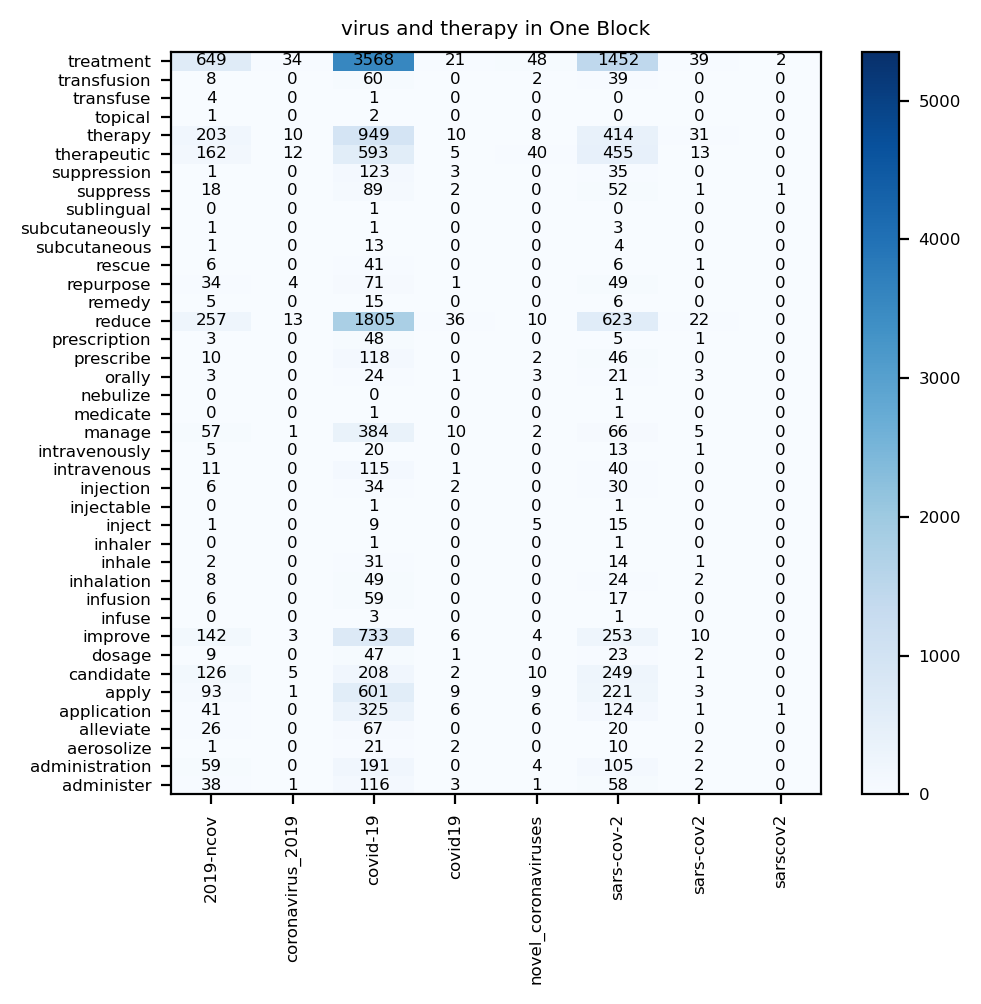

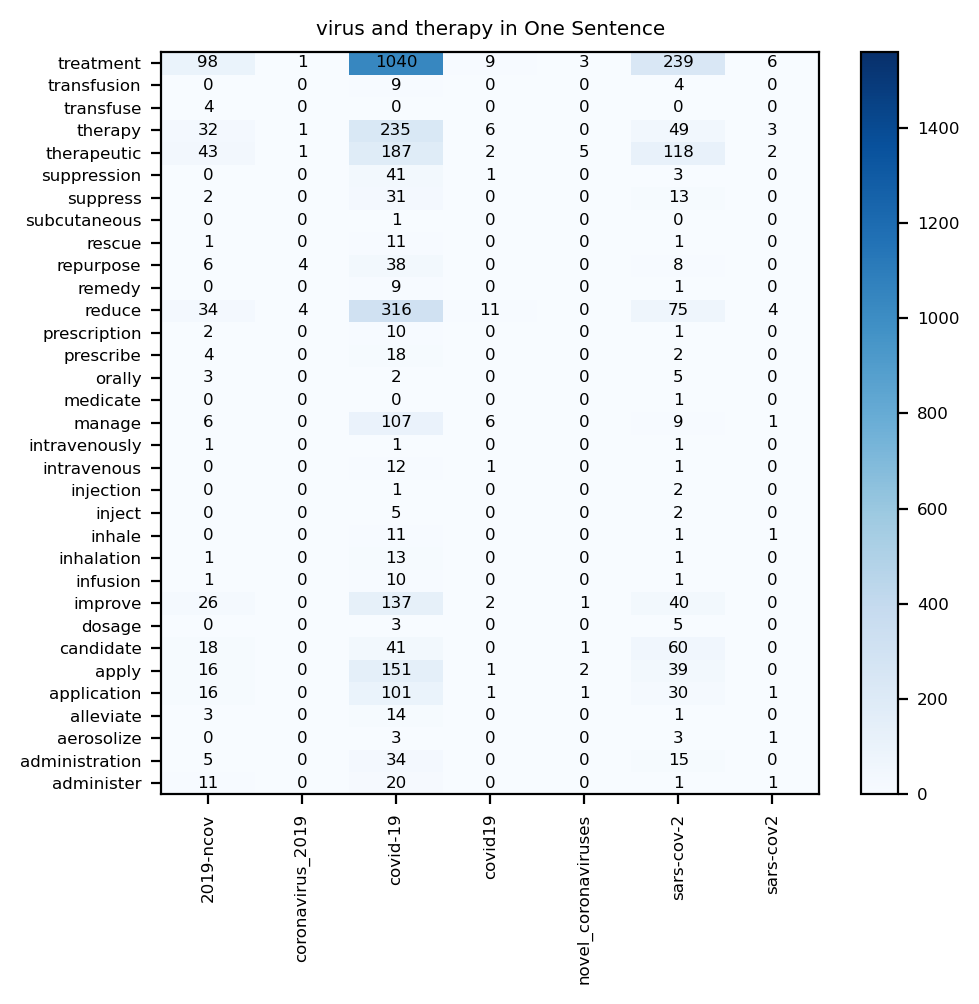

In [136]:
Make2DPlot(dat_joined_vt,"virus","therapy")
Make2DPlot(dat_joined_vt,"virus","therapy",single_sentence_plots=True)

Virus / Drug co-occurrences

In [137]:
# Prune and join, and extract overlap counts
dat_joined_vd=dat_drugs.join(dat_viruses, rsuffix='_virus',lsuffix="_drug")
dat_joined_vd=dat_joined_vd[dat_joined_vd.notna().word_drug & dat_joined_vd.notna().word_virus]

dat_joined_vd=dat_joined_vd.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_virus":"sha","blockid_virus":"blockid","sec_virus":"sec"})
SingleSentence=[]
for i in dat_joined_vd.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_vd.block[i],dat_joined_vd.pos_drug[i],dat_joined_vd.pos_drug[i]))
dat_joined_vd.insert(len(dat_joined_vd.columns),'same_sentence',SingleSentence)
dat_joined_vd.to_csv("Overlaps_Virus_Drug.csv")


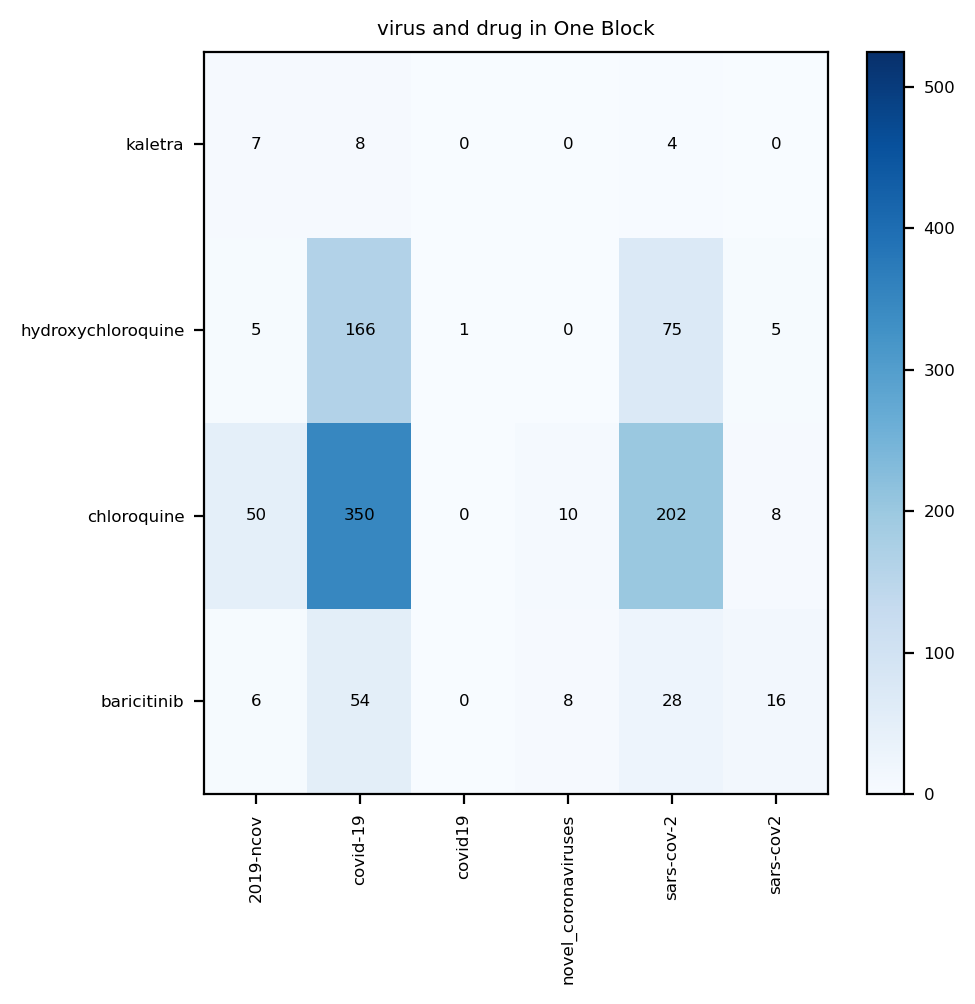

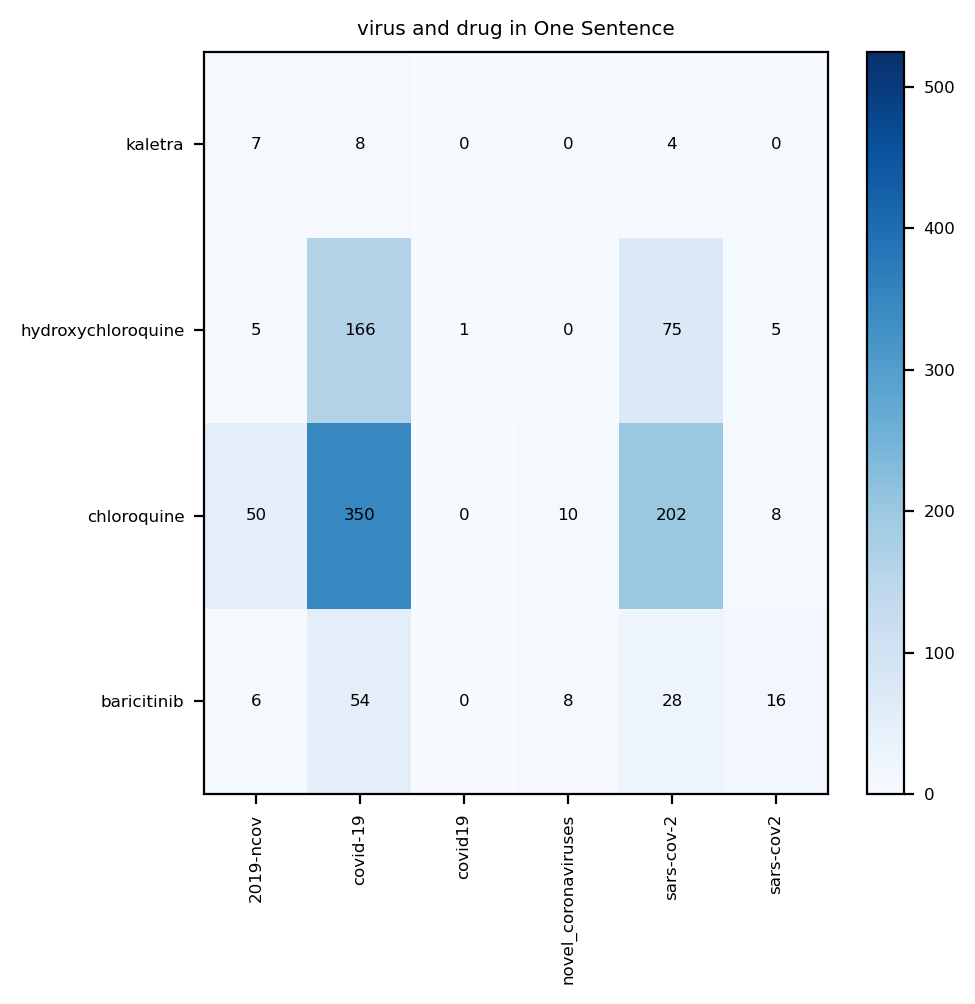

In [138]:
drugsubset=["naproxen","clarithromycin","chloroquine","kaletra","Favipiravir","Avigan",'hydroxychloroquine','baricitinib']
Make2DPlot(dat_joined_vd[dat_joined_vd.word_drug.isin(drugsubset)],"virus","drug")
Make2DPlot(dat_joined_vd[dat_joined_vd.word_drug.isin(drugsubset)],"virus","drug",single_sentence_plots=True)

Drug / Therapy co-occurrences


In [139]:
# Prune and join, and extract overlap counts
dat_joined_dt=dat_drugs.join(dat_therapies, rsuffix='_therapy',lsuffix="_drug")
dat_joined_dt=dat_joined_dt[dat_joined_dt.notna().word_drug & dat_joined_dt.notna().word_therapy]

dat_joined_dt=dat_joined_dt.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_therapy":"sha","blockid_therapy":"blockid","sec_therapy":"sec"})
SingleSentence=[]
for i in dat_joined_dt.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_dt.block[i],dat_joined_dt.pos_drug[i],dat_joined_dt.pos_therapy[i]))
dat_joined_dt.insert(len(dat_joined_dt.columns),'same_sentence',SingleSentence)
dat_joined_dt.to_csv("Overlaps_Drug_Therapy.csv")

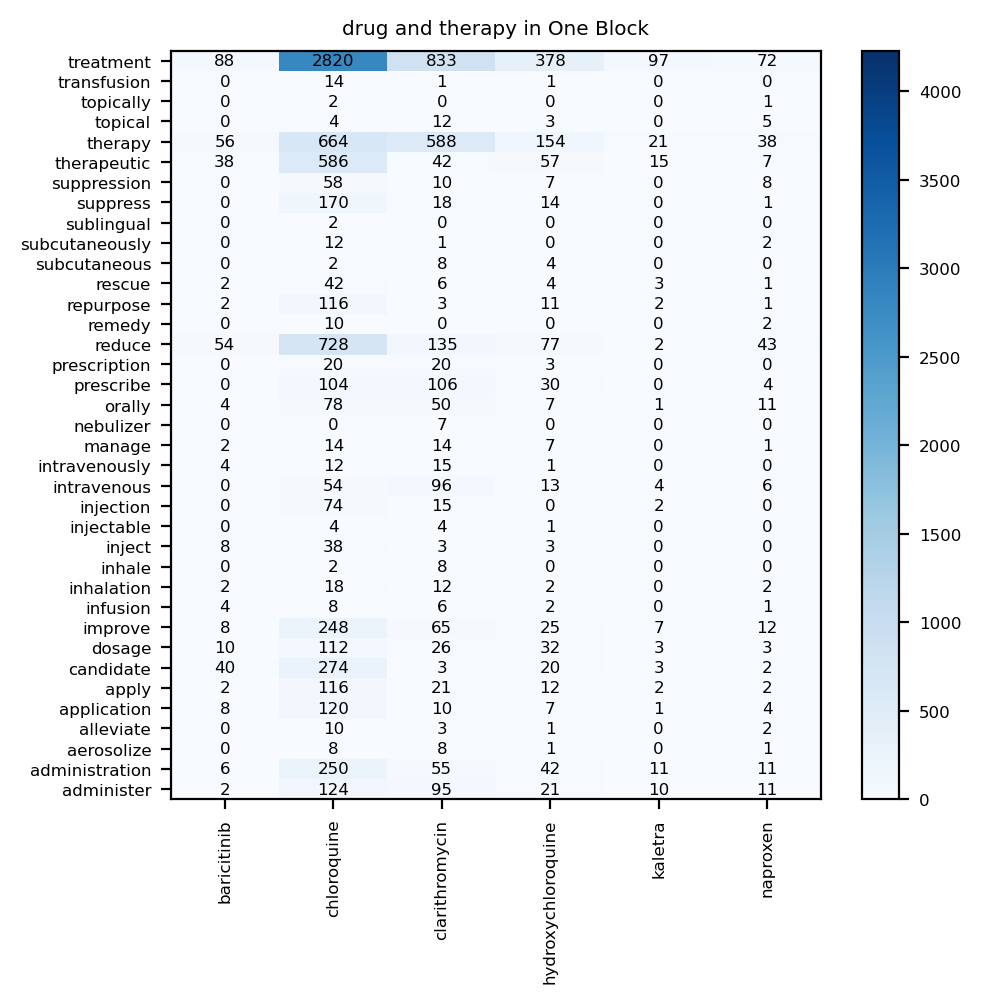

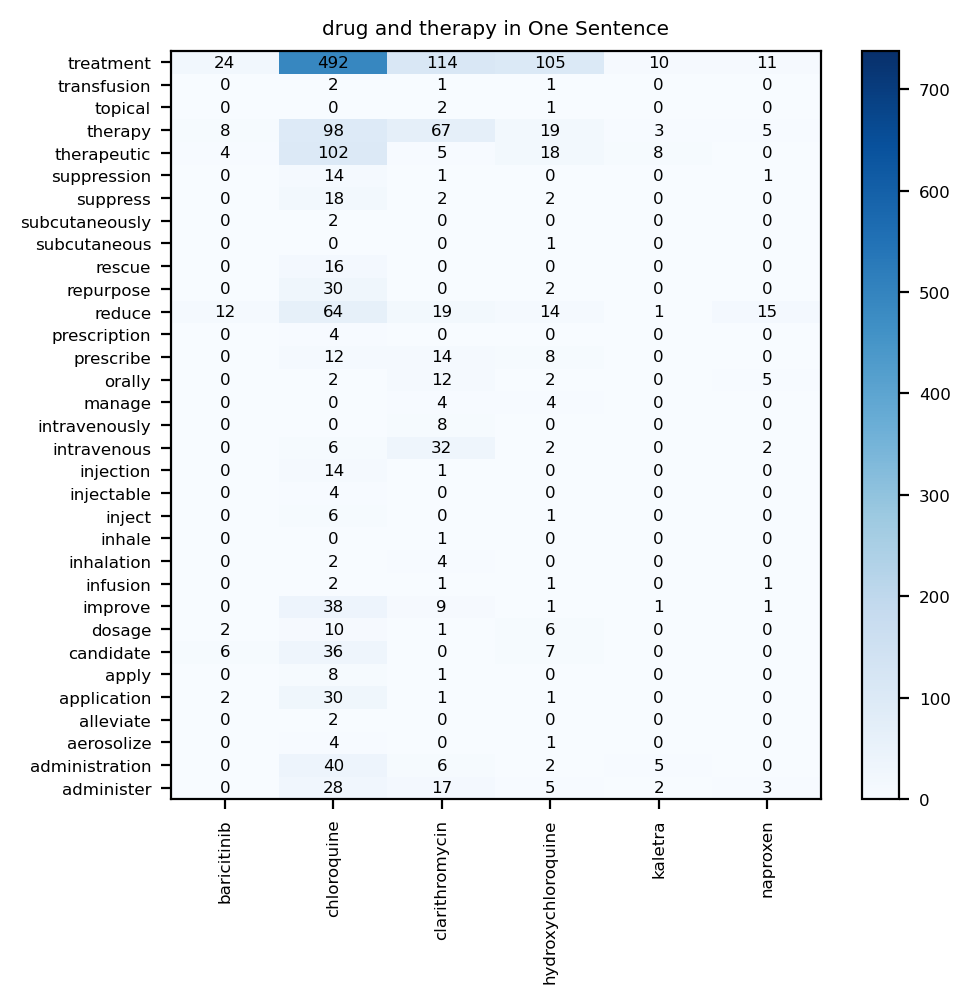

In [140]:
Make2DPlot(dat_joined_dt[dat_joined_dt.word_drug.isin(drugsubset)],"drug","therapy")
Make2DPlot(dat_joined_dt[dat_joined_dt.word_drug.isin(drugsubset)],"drug","therapy",single_sentence_plots=True)

Study type / drug co-occurrences

In [141]:
# Prune and join, and extract overlap counts
dat_joined_de=dat_drugs.join(dat_exps, rsuffix='_exp',lsuffix="_drug")
dat_joined_de=dat_joined_de[dat_joined_de.notna().word_drug & dat_joined_de.notna().word_exp]

dat_joined_de=dat_joined_de.drop(["sha_drug","blockid_drug","sec_drug"],axis=1).reset_index().rename(columns={"sha_exp":"sha","blockid_exp":"blockid","sec_exp":"sec"})
SingleSentence=[]
for i in dat_joined_de.index:
    SingleSentence.append(SameSentenceCheck(dat_joined_de.block[i],dat_joined_de.pos_drug[i],dat_joined_de.pos_exp[i]))
dat_joined_de.insert(len(dat_joined_de.columns),'same_sentence',SingleSentence)
dat_joined_de.to_csv("Overlaps_Drug_Experiment.csv")

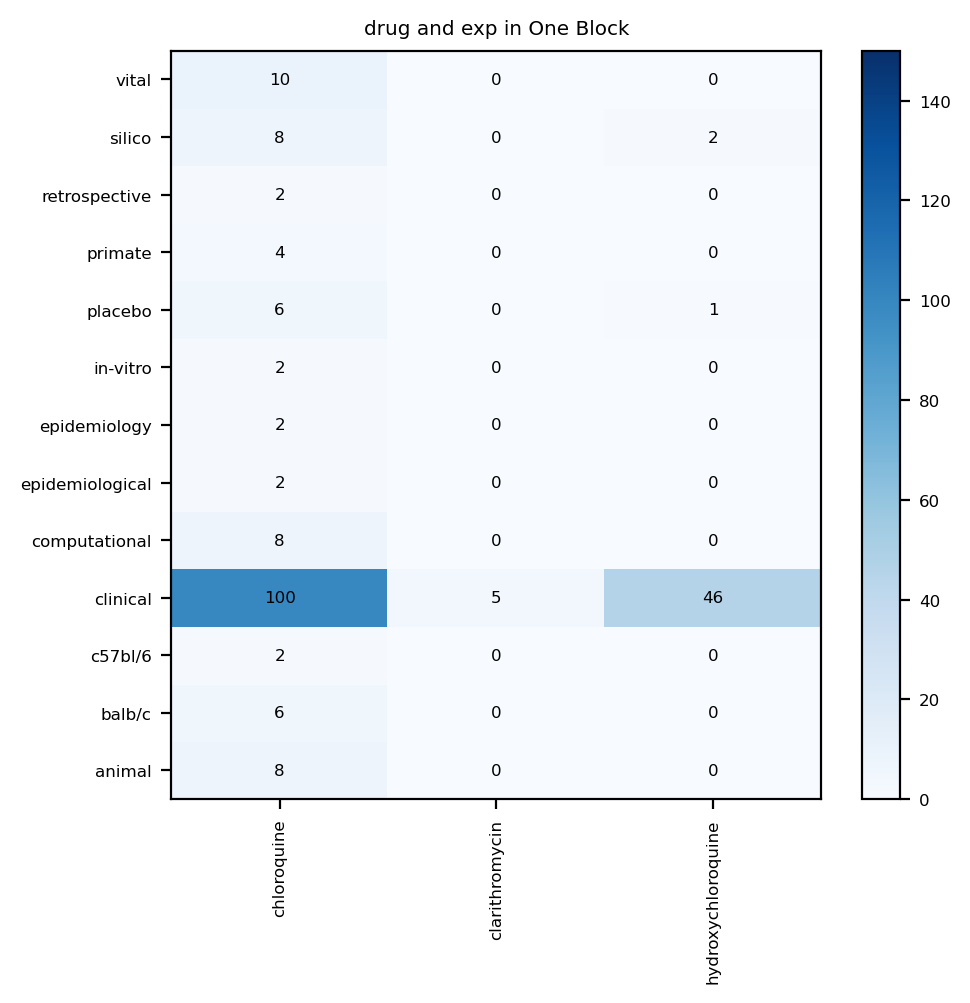

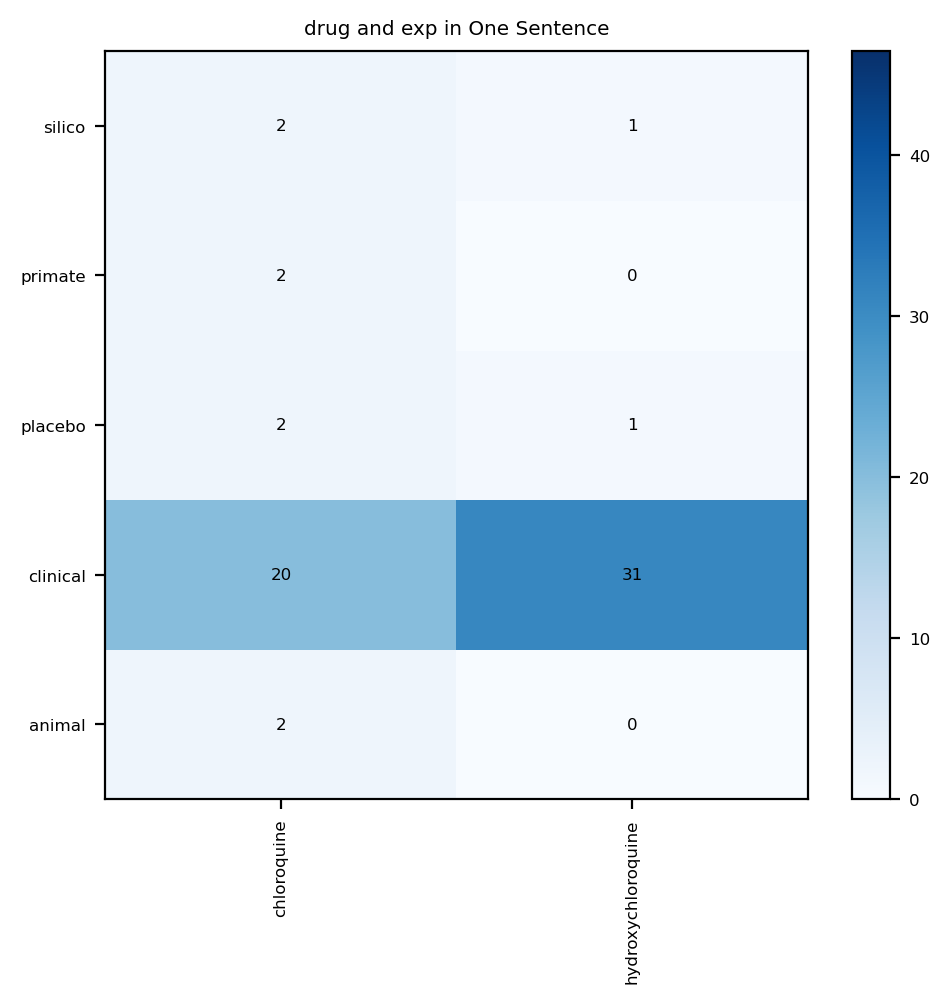

In [142]:
Make2DPlot(dat_joined_de[dat_joined_de.word_drug.isin(drugsubset)],"drug","exp")
Make2DPlot(dat_joined_de[dat_joined_de.word_drug.isin(drugsubset)],"drug","exp",single_sentence_plots=True)

Tripartite co-occurrences

In [143]:
dat_joined_vtd=dat_therapies.join(dat_viruses, rsuffix='_virus',lsuffix="_therapy").join(dat_drugs)
dat_joined_vtd=dat_joined_vtd[dat_joined_vtd.notna().word_therapy & dat_joined_vtd.notna().word_virus & dat_joined_vtd.notna().word]
grouped_vtd=dat_joined_vtd.groupby(['word_therapy','word_virus','word'])
grouped_vtd.count().sha_therapy

word_therapy  word_virus  word           
administer    2019-ncov   arbidol             1
                          cefepime            3
                          chloroquine         4
                          corticosteroids     1
                          eidd-2801           1
                                             ..
treatment     sars-cov2   lopinavir           6
                          remdesivir          4
                          ribavirin           6
                          sarilumab           2
                          tocilizumab        20
Name: sha_therapy, Length: 3174, dtype: int64

In [144]:
dat_joined_vtd=dat_joined_vtd.reset_index().drop(['sha_therapy','blockid_therapy','sec_therapy','sha_virus','blockid_virus','sec_virus'],axis=1).rename(columns={'word':'word_drug','pos':'pos_drug'}).set_index('sha')
dat_joined_vtd=dat_joined_vtd[["block","sec","blockid","word_therapy","pos_therapy","word_virus", "pos_virus","word_drug","pos_drug"]]
dat_joined_vtd.to_csv("Overlaps_Drug_Therapy_Virus.csv")


### Preparation for Visualization
This section implements some data manipulation and cleaning to prepare for visualization.

In [145]:
dat_viruses.word.value_counts()

covid-19               17878
sars-cov-2              7927
2019-ncov               2950
covid19                  240
novel_coronaviruses      217
sars-cov2                210
coronavirus_2019         108
sarscov2                  10
sars-cov_2                 1
Name: word, dtype: int64

In [146]:

OverlapsVirus=pd.read_csv("./Overlaps_Virus_Drug.csv")
OverlapsTherapy=pd.read_csv("./Overlaps_Drug_Therapy.csv")

VirusWords=['novel_coronavirus','covid-19','2019-ncov','sars-cov-2','sars-cov_2']

PapersWithVirusDrugOverlap=OverlapsVirus[OverlapsVirus.word_virus.isin(VirusWords)].sha.unique()
PapersWithVirusMention=dat_viruses[dat_viruses.word.isin(VirusWords)].sha.unique()
OverlapsTherapy=OverlapsTherapy[OverlapsTherapy.same_sentence==1]


In [147]:
# This two helper function does its best to extract the year from the 
#  inconsistently formatted metadata

def ConvertDateToYear(datestring):
    import dateutil.parser as parser

    if(pd.notna(datestring)):
        try:
            date=parser.parse(str(datestring),fuzzy=True)
            return date.year
        except ValueError:
            return 0
    else:
        return 0
    



In [148]:
# Take the elements we need out of the paper metadata
meta=pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
years=meta.publish_time.apply(ConvertDateToYear)
meta.insert(len(meta.columns),'year',years)
meta_to_use=meta.set_index('sha')[['doi','title','year','abstract','journal','cord_uid']]

# And mix it in
OverlapsTherapy=OverlapsTherapy.set_index('sha').join(meta_to_use).reset_index()

In [149]:
if(InsertCiteData):
    citefile=pd.read_csv("/kaggle/input/coronawhy/cord19_MicrosoftAcademic_citation_metadata.csv").set_index('cord_uid')['CitationCount']
    OverlapsTherapy=OverlapsTherapy.set_index('cord_uid').join(citefile).reset_index()

In [150]:
# Extract the relevant sentences where matches were found
SentenceEnders="\. |; \! \? "
ExtractedSentences=[]
for i in OverlapsTherapy.index:
    sentences = re.split(SentenceEnders,OverlapsTherapy.block.loc[i])
    RunningCount=0
    ExtractedSentences.append(np.NaN)

    for s in range(0,len(sentences)):
        RunningCount=RunningCount+len(sentences[s])
        if(OverlapsTherapy.pos_drug.loc[i]<RunningCount):
            ExtractedSentences[-1]=sentences[s]
            break
            
OverlapsTherapy.insert(len(OverlapsTherapy.columns),'sentence',ExtractedSentences)

In [151]:
# Check for coincidences in block and paper
CoronaInPaper=OverlapsTherapy.sha.isin(PapersWithVirusMention)
CoronaInBlock=OverlapsTherapy.sha.isin(PapersWithVirusDrugOverlap)
OverlapsTherapy.insert(len(OverlapsTherapy.columns),'corona_paper',CoronaInPaper)
OverlapsTherapy.insert(len(OverlapsTherapy.columns),'corona_block',CoronaInBlock)

In [152]:
#Tidy and trim
OverlapsTherapy=OverlapsTherapy.rename(columns={'word_drug':'drug','sec':'section','block':'paragraph'}).drop(['blockid','pos_drug','pos_therapy','Unnamed: 0','same_sentence'],axis=1)

In [153]:
# This is the final file that is used as input to the visualization stage
OverlapsTherapy=OverlapsTherapy.drop_duplicates()
OverlapsTherapy.to_csv("DrugVisData.csv")

### Negation Detection

A trigger term list (citation1) is used to identify negation for each extracted drug-treatment co-occurence.

Pros:

* Quick and easy approach

Cons:

* Sentence hierarchical structure is not accounted for. Contrastive conjunctions (but, however, etc.) and long sentences with each part talking about different drugs could cause false positives.

We follow the methods of "Clinical Text Summarization with Syntax-Based Negation and Semantic Concept Identification", Weng, Wei-Hung et al, 2020, arXiv arXiv:2003.00353.

In [154]:
if(CalculateNegations):

    data = OverlapsTherapy
    output_data = data
    out_dir = './'


    # negated term list (use the human annotated version)
    neg_list = pd.read_csv('/kaggle/input/negation-words/neg_list_complete.txt', sep='\t', header=0)
    neg = neg_list['ITEM'].values
    neg_term = [' ' + item + ' ' for item in neg]
    neg_term.extend(item + ' ' for item in neg)


    for i in data.index:
        if pd.isnull(data.loc[i,'sentence']):
            output_data.loc[i,'match_quality'] = 2
        else:
            # tag negated or affirmed based on string matching --- negation term list
            # add one space to prevent loss of 'no ', 'not ', ... etc.
            if any(substring in ' ' + data.loc[i,'sentence'].lower() for substring in neg_term):
                output_data.loc[i,'match_quality'] = 1
            else:
                output_data.loc[i,'match_quality'] = 2

    # save results in a output file
    output_data.to_csv('DrugVisData.csv',index=False)

Let's take a look at the most negated and most asserted drugs based on number of mentions:

In [155]:
if(CalculateNegations):
    negated_drug_mentions = output_data.loc[output_data.match_quality==2,'drug']\
                                        .groupby(output_data['drug'])\
                                        .value_counts()\
                                        .droplevel(level=0)
    print('Top 20 most negated drugs:\n')
    print(negated_drug_mentions.nlargest(20))

Top 20 most negated drugs:

drug
corticosteroids       2582
ribavirin             2262
oseltamivir           1391
methylprednisolone     768
zanamivir              677
amoxicillin            617
pegylated              570
dexamethasone          565
prednisolone           564
azithromycin           525
acyclovir              519
nitric_oxide           502
doxycycline            497
cholesterol            466
ganciclovir            463
metronidazole          450
prednisone             442
trypsin                409
influenza_a_virus      401
vancomycin             397
Name: drug, dtype: int64


Now, let's look at the distribution of percentage negated mentions for drugs:

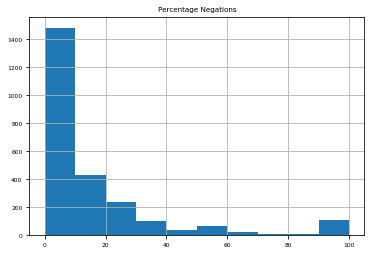

In [156]:
if(CalculateNegations):
    drug_mentions = output_data.groupby([output_data['drug'],output_data.match_quality])\
                                .size().to_frame(name = 'size').reset_index()\
                                .pivot(index='drug',columns='match_quality',values='size').fillna(0).reset_index()

    drug_mentions['Percentage Negations'] = (drug_mentions[1]*100)/(drug_mentions[2]+drug_mentions[1])

    drug_mentions.hist(column='Percentage Negations')

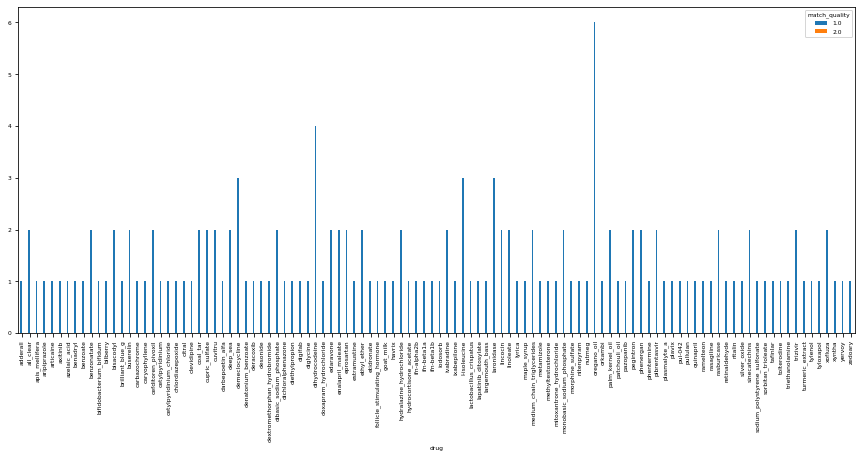

In [157]:
if(CalculateNegations):
    # Drugs with 100% negation
    drug_mentions.nlargest(n=1,columns='Percentage Negations',keep='all').plot.bar('drug',[1.0,2.0],figsize=(15,6))

### Relation Extraction Model 

The below is a basic relation classification model trained at the following link https://github.com/CoronaWhy/task-vt/pull/16/files and inspired by https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta. The goal of this model is given a sentence with a drug and a treatment classify if the treatment is actually related to the drug.

In [158]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

In [159]:
!mkdir model_dir
#!gsutil cp gs://coronaviruspublicdata/re_final_best/new/config.json model_dir/config.json
#!gsutil cp gs://coronaviruspublicdata/re_final_best/new/sigmoid.pickle model_dir/sigmoid.pickle
#!gsutil cp gs://coronaviruspublicdata/re_final_best/new/tf_model.h5 model_dir/tf_model.h5
# Snapshot weights below uncomment if you want to use
!gsutil cp gs://coronaviruspublicdata/re_snapshot/4_13_2020/config.json model_dir/config.json
!gsutil cp gs://coronaviruspublicdata/re_snapshot/4_13_2020/sigmoid.pickle model_dir/sigmoid.pickle
!gsutil cp gs://coronaviruspublicdata/re_snapshot/4_13_2020/tf_model.h5 model_dir/tf_model.h5

mkdir: cannot create directory ‘model_dir’: File exists
Copying gs://coronaviruspublicdata/re_snapshot/4_13_2020/config.json...
/ [1 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 1 objects/1.2 KiB.                                      
Copying gs://coronaviruspublicdata/re_snapshot/4_13_2020/sigmoid.pickle...
/ [1 files][  3.2 KiB/  3.2 KiB]                                                
Operation completed over 1 objects/3.2 KiB.                                      
Copying gs://coronaviruspublicdata/re_snapshot/4_13_2020/tf_model.h5...
/ [1 files][475.7 MiB/475.7 MiB]                                                
Operation completed over 1 objects/475.7 MiB.                                    


In [160]:
def build_model(transformer, max_len=256):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_ids = Input(shape=(max_len, ), dtype=tf.int32)

    x = transformer(input_ids)[0]
    x = x[:, 0, :]
    x = Dense(1, activation='sigmoid', name='sigmoid')(x)

    # BUILD AND COMPILE MODEL
    model = Model(inputs=input_ids, outputs=x)
    model.compile(
        loss='binary_crossentropy', 
        metrics=['accuracy'], 
        optimizer=Adam(lr=1e-5)
    )
    return model

def save_model(model, transformer_dir='transformer'):
    """
    Special function to load a keras model that uses a transformer layer
    """
    transformer = model.layers[1]
    touch_dir(transformer_dir)
    transformer.save_pretrained(transformer_dir)
    sigmoid = model.get_layer('sigmoid').get_weights()
    pickle.dump(sigmoid, open('sigmoid.pickle', 'wb'))

def load_model(pickle_path, transformer_dir='transformer', max_len=512):
    """
    Special function to load a keras model that uses a transformer layer
    """
    transformer = TFAutoModel.from_pretrained(transformer_dir)
    model = build_model(transformer, max_len=max_len)
    sigmoid = pickle.load(open(pickle_path, 'rb'))
    model.get_layer('sigmoid').set_weights(sigmoid)
    
    return model



In [161]:
model = load_model("model_dir/sigmoid.pickle", "model_dir")

In [162]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [163]:
tokenizer = AutoTokenizer.from_pretrained("allenai/biomed_roberta_base")

In [164]:
def MagicClassifierFunction(sentence, tokenizer):
    encode_text = regular_encode(sentence, tokenizer)
    preds = model.predict(encode_text)
    BooleanDecision = (preds >= .4) 
    return BooleanDecision 

In [165]:
# Due to runtime constraints on kaggle we can only apply the ML classifier to a subset.
# Given less restriction on submission we could apply to all...
#SelectionToML=(output_data.corona_paper==True) & (output_data.section.isin(['title','abstract'])&output_data.notna().sentence)
SelectionToML=(output_data.corona_paper==True) & (output_data.notna().sentence)
SentencesForML=output_data[SelectionToML].sentence.unique()


In [166]:
# Run the classifier
%time preds=MagicClassifierFunction(SentencesForML,tokenizer)


CPU times: user 2h 17min 47s, sys: 16min 35s, total: 2h 34min 23s
Wall time: 41min 39s


In [167]:
for i in SentencesForML[preds[:,0]]:
    output_data.match_quality[i == output_data.sentence]=3

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [168]:
#Do not allow claim as covid-19 papers any from before 2019
output_data.corona_paper[output_data.year<2019]=False
output_data.corona_block[output_data.year<2019]=False

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [169]:
output_data=output_data.reset_index()
output_data=output_data.set_index("cord_uid")
output_data.to_csv("DrugVisData.csv")

### Making the matrix for the study-types plot

In [170]:
TitleAndAbstractMentions=dat_exps[(dat_exps.sec=='title') | (dat_exps.sec=='abstract')].set_index('sha')

IndicatorMatrix=pd.read_csv("/kaggle/working/DrugVisData.csv")
IndicatorMatrix=IndicatorMatrix.set_index('sha').join(TitleAndAbstractMentions)
IndicatorMatrix=IndicatorMatrix[IndicatorMatrix.notna().word].rename({"word":"study_word"},axis=1)

# Load data we need to make the categorization of study words into 
#  paper category indications
catfile=np.loadtxt("/kaggle/input/textmatchesvt/study_classes.csv",dtype='str', delimiter=',')
categories=np.unique([i.lower() for i in catfile[:,1]])
for cat in categories:
    IndicatorMatrix[cat]=False
for c in catfile:
    word=c[0].lower().replace(" ", "_")
    category=c[1].lower().replace(" ", "_")
    IndicatorMatrix.loc[(IndicatorMatrix.study_word==word),category]=True

# Build up new data structure with categorization judgements
IndicatorMatrix=IndicatorMatrix.reset_index()
gb=IndicatorMatrix.groupby(by=['sha','drug'])
cat_scores={}
for c in categories:
    cat_scores[c]=[]
shas=[]
drugs=[]
clinical_score=[]
gb_groups = gb.groups
for g in gb_groups.keys():
    records=IndicatorMatrix.iloc[gb_groups[g]]
    shas.append(g[0])
    drugs.append(g[1])
    for c in categories:
        cat_scores[c].append(sum(records[c]))
data=[shas,drugs]
colnames=['sha','drugs']
for c in categories:
    data.append(cat_scores[c])
    colnames.append(c)
studydata=pd.DataFrame(np.array(data).T,columns=colnames)
for c in categories:
    studydata[c]=studydata[c].apply(pd.to_numeric)
studydata.insert(len(studydata.columns),'category',np.NaN)
   
    

In [171]:
# Papers are categorized by "popular vote" by search term.

print("Paper classifications by 'popular vote'" )
print("=======================================")
print("No Category: " + str(len(studydata[studydata[categories].max(axis=1)==0].sha.unique())))
for cat in categories:
    print(cat + ": "+  str(len(studydata[(studydata[categories].max(axis=1)==studydata[cat]) & (studydata[categories].max(axis=1)>0)].sha.unique())))
    studydata.category[(studydata[categories].max(axis=1)==studydata[cat]) & (studydata[categories].max(axis=1)>0)]=cat
    
IndicatorMatrix.drop('study_word',axis=1).drop_duplicates()
studydata=studydata[['sha','category']].drop_duplicates().set_index('sha')
IndicatorMatrix=IndicatorMatrix=IndicatorMatrix.set_index('sha').join(studydata).reset_index().rename({"category":"word"},axis=1)    
#IndicatorFields=['sha','paragraph','drug','section','doi','title','year','abstract','sentence','corona_paper','corona_block','word','sec','match_quality']


Paper classifications by 'popular vote'
No Category: 146
clinical: 2784
in-silico: 204
in-vitro: 26
pre-clinical: 1260


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [172]:
ForGeoMatch=IndicatorMatrix[(IndicatorMatrix.word=='clinical')&(IndicatorMatrix.corona_paper==True)][['sha','cord_uid','drug','year','doi']]
ForGeoMatch=ForGeoMatch.drop_duplicates()
ForGeoMatch.to_csv("ClinicalPapers_ForGeo.csv")

In [173]:
IndicatorMatrix=IndicatorMatrix.drop(['blockid', 'study_word', 'pos', 'clinical', 'in-silico', 'in-vitro','pre-clinical'],axis=1).drop_duplicates()
IndicatorMatrix.to_csv("IndicatorMatrix.csv")

# List of Contributors (alphabetical) <a id="contrib"></a>

This notebook was produced by the Task-VT subgroup of the CoronaWhy research consortium.  We acknowledge significant scientific or technical contributions to this notebook from the following: 


**Hillary Adragna**: Pharmacology consultant

**Mahmoud Bahaa**: NLP/ML Developer

**Sam Brewer**: Lead Visualization Developer

**Aradhana Chaturvedi**: NLP/ML Developer

**Isaac Godfried**: NLP/ML Developer 

**Mike Honey**: Visualization Consultant

**Ben Jones**: Lead Data Analysis Developer

**Andrea Kropp**: NLP / Search Term Enrichment

**Siddharta Mitra**: Development support and annotation

**Dan Sosa**: Task-VT Team Coordinator

**Malakiva Suresh**: NLP/ML Developer

